# Setup  Directories

In [1]:
!  [ -d output ] || mkdir output ; [ -d figures ] || mkdir figures

# Load Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit,minimize
from glob import glob

In [3]:
def angfunk(alpha,beta,phase):
    tanhalfC=np.tan(phase*np.pi)
    halfamb=np.radians(alpha-beta)/2
    halfapb=np.radians(alpha+beta)/2
    halfAmB=np.arctan2(np.sin(halfamb),np.sin(halfapb)*tanhalfC)
    halfApB=np.arctan2(np.cos(halfamb),np.cos(halfapb)*tanhalfC)
    return (halfApB-halfAmB)

def angfunk2(alpha,beta,phase):
    a=np.radians(alpha)
    b=np.radians(beta)
    sbeta=np.sin(b)
    p=phase*2*np.pi
    return np.arctan2(sbeta*np.sin(p),(np.cos(b)*np.sin(a)-sbeta*np.cos(a)*np.cos(p)))
def costheta(alpha,beta,phase):
    a=np.radians(alpha)
    b=np.radians(beta)
    return np.cos(a)*np.cos(b)+np.sin(a)*np.sin(b)*np.cos(phase*2*np.pi) 

# Load Data and Modulation Fraction

In [4]:
# point this to wherever the IXPE Calb files are located
CALB_DIR='/home/idies/workspace/headata/FTP/caldb/data'
OBSID='01250201'
# point this to wherever the IXPE data files are located -- this is on sciserver.org
datafile='/home/idies/workspace/headata/FTP/ixpe/data/obs/%s/%s/event_l2/ixpe%s_det?_evt2_v02.fits.gz' % (OBSID[0:2],OBSID,OBSID)
#datafile='/home/idies/workspace/Temporary/heyl/scratch/1RXS/01003199/event_l2/*1.fits.gz'
#for i,f in enumerate(sorted(glob('01003299/event_l2/ixpe01003299_det?_evt2_v02_geocenter.fits.gz'))):
for i,f in enumerate(sorted(glob(datafile))): 
    print(i,f)
    with fits.open('%s/ixpe/gpd/cpf/modfact/ixpe_d%d_20170101_mfact_02.fits' % (CALB_DIR,i+1)) as hdu:
        modlist=hdu[1].data['SPECRESP']
    with fits.open(f) as hdu:
        # hdu[1].data['PI']=pislope[i]*hdu[1].data['PI']+pioffset[i]
        if (i==0):
            MJDREFI=hdu[0].header['MJDREFI']
            MJDREFF=hdu[0].header['MJDREFF']
            LIVETIME=hdu[0].header['LIVETIME']
            evtlist=hdu[1].data
            moddata=np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])
            detector=np.full(len(hdu[1].data),i+1)
        else:
            evtlist=np.append(evtlist,hdu[1].data)
            moddata=np.concatenate((moddata,np.transpose(modlist[np.clip(hdu[1].data['PI']-25,0,len(modlist)-1)])))
            detector=np.concatenate((detector,np.full(len(hdu[1].data),i+1)))


0 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01250201/event_l2/ixpe01250201_det1_evt2_v02.fits.gz
1 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01250201/event_l2/ixpe01250201_det2_evt2_v02.fits.gz
2 /home/idies/workspace/headata/FTP/ixpe/data/obs/01/01250201/event_l2/ixpe01250201_det3_evt2_v02.fits.gz


In [5]:
xc, yc=300, 300
for _i in range(5):
    rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
    ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<50) 
    xc,yc=np.mean(evtlist['X'][ok]),np.mean(evtlist['Y'][ok])
    print(xc,yc)
rr=np.hypot(evtlist['X']-xc,evtlist['Y']-yc)
ok=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr<20) 
back=(evtlist['PI']>49) & (evtlist['PI']<=200) & (rr>30)  & (rr<50)
evtback=evtlist[back]
evtlist=evtlist[ok]
modback=moddata[back]
moddata=moddata[ok]
detback=detector[back]
detector=detector[ok]


301.3189 304.74167
301.3597 304.88684
301.3612 304.89142
301.3612 304.89145
301.3612 304.89145


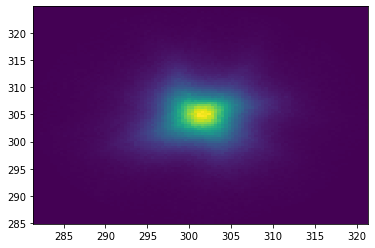

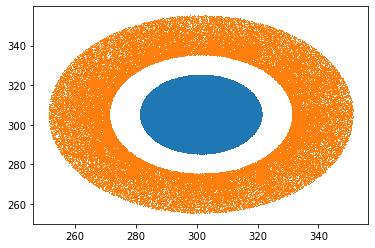

In [6]:
plt.hist2d(evtlist['X'],evtlist['Y'],bins=100)
plt.show()
plt.plot(evtlist['X'],evtlist['Y'],',')
plt.plot(evtback['X'],evtback['Y'],',')

In [7]:
pispec=np.histogram(evtlist['PI'],bins=150)[0]
np.save('output/pispec',pispec)

In [8]:
backpispec=np.histogram(evtback['PI'],bins=150)[0]*20**2/(50**2-30**2)
np.save('output/backpispec',backpispec)

In [9]:
for i in range(1,4):
    _q,_u=np.mean((evtlist['Q']/moddata)[detector==i]),np.mean((evtlist['U']/moddata)[detector==i])
    print(i,_q,_u,np.hypot(_q,_u))

1 -0.0026278792661364203 0.060483889717658945 0.060540950313117146
2 -0.014401953596030888 0.0627799050841303 0.06441065711320322
3 -0.016574992955302615 0.05172885169861504 0.05431946694809918


# Barycentring First Try with GBM Orbital Elements

In [10]:
dobary=True
if dobary:
    ! [ -f cenx3.fits.gz ] || curl https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/cenx3.fits.gz --output cenx3.fits.gz
    with fits.open('cenx3.fits.gz')  as hdu:
        orbitdata=hdu['Orbital Elements'].data
        spindata=hdu['PSR_HIST'].data
    day=3600*24
    TPIOVER2O=orbitdata['BINARYEPOCH']-2400000
    PORB=orbitdata['PBINARY']*day
    PORBDOT=orbitdata['PBDOT']
    ECCENTRICITY=orbitdata['ECCENTRICITY']
    OMEGA=orbitdata['PERIAPSE']
    ASINIOVERC=orbitdata['AXSINI']
    NUORB=1/PORB
    NUORBDOT=-1/PORB/PORB*PORBDOT
    met0=evtlist['TIME'].min()
    MJDSTART=MJDREFF+MJDREFI+met0/day
    NU=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FREQUENCY'])
    NUDOT=np.interp(MJDSTART,spindata['BARYTIME'],spindata['FDOT'])
    TREFNU=MJDSTART
    torb=((MJDREFF+MJDREFI)+evtlist['TIME']/day-TPIOVER2O)*day
    phaseorb=(0.25+torb*(NUORB+torb*NUORBDOT/2))                    
    orbtime=ASINIOVERC*((np.cos(2*np.pi*phaseorb)-np.cos(np.pi/2))-
                    0.5*ECCENTRICITY*(np.sin(4*np.pi*phaseorb-np.radians(OMEGA))-
                                      np.sin(np.pi/2-np.radians(OMEGA))))
    deltat=evtlist['TIME']-met0-orbtime
    freqtst=NU
else:
    deltat=evtlist['TIME']-evtlist['TIME'].min()
    freqtst=1/8.68832905

## Lomb-Scargle

In [11]:
from astropy.timeseries import LombScargle
ls = LombScargle(deltat,np.ones(len(deltat)))
lsu = LombScargle(deltat,evtlist['U']*moddata)
lsq = LombScargle(deltat,evtlist['Q']*moddata)

In [12]:
freqq,powerq = lsq.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)
frequ,poweru = lsu.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)

In [13]:
freq,power = ls.autopower(minimum_frequency=freqtst*0.99,maximum_frequency=freqtst*1.01,samples_per_peak=50)
freqmax=freq[np.argmax(power)]
print(freqmax,freqmax-freqtst)

0.2085140076453364 2.1068330599283147e-06


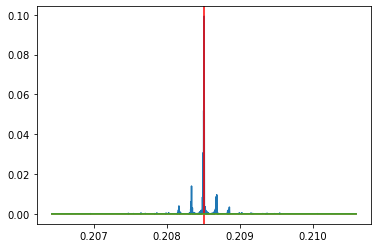

In [14]:
plt.plot(freq,power)
plt.axvline(freqmax,c='r')
plt.plot(frequ,poweru)
plt.plot(freqq,powerq)

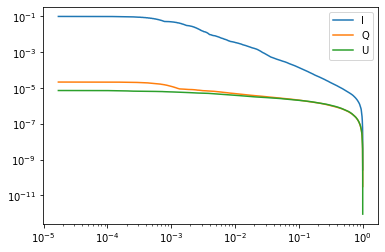

In [15]:
plt.loglog(np.linspace(1,len(power),len(power))/len(power),-np.sort(-power),label='I')
plt.loglog(np.linspace(1,len(powerq),len(powerq))/len(powerq),-np.sort(-powerq),label='Q')
plt.loglog(np.linspace(1,len(poweru),len(poweru))/len(poweru),-np.sort(-poweru),label='U')
plt.legend()

In [16]:
_dt=deltat
def calcppow(xx,kmax=2):
    _fff=xx[0]
    _fdf=xx[1]
    phase=2*np.pi*(_dt*(_fff+_dt*_fdf*0.5))
    if kmax>1:
        sphase=np.sin(phase)
        cphase=np.cos(phase)
        snphase=sphase
        cnphase=cphase
        pppow=np.sum(snphase)**2+np.sum(cnphase)**2
        for _j in range(2,kmax+1):
            _snphase=snphase*cphase+cnphase*sphase
            cnphase=cnphase*cphase-snphase*sphase
            snphase=_snphase
            pppow+=np.sum(snphase)**2+np.sum(cnphase)**2
    else:
        pppow=np.sum(np.sin(phase))**2+np.sum(np.cos(phase))**2
    return(-pppow)  

In [17]:
print(calcppow([freqmax,-3e-15]))
respow=minimize(calcppow,[freqmax,-3e-15],method='Nelder-Mead')
print(respow.fun,respow.x)
respow=minimize(calcppow,respow.x)
print(respow.fun,respow.x)

-287033032914.0908
-289282562372.2851 [2.08513437e-01 3.66936159e-12]
-289282562372.2851 [2.08513437e-01 3.66936159e-12]


In [18]:
print(freqmax,respow.x)

0.2085140076453364 [2.08513437e-01 3.66936159e-12]


## Folding

0.4925667756461662


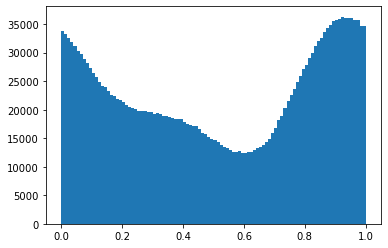

In [19]:
phdata=np.mod(deltat*(respow.x[0]+deltat*respow.x[1]*0.5),1)
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

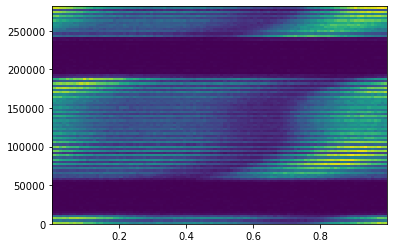

In [20]:
bindata=plt.hist2d(phdata,deltat,bins=100)

This looks like the orbital elements need correction.  Let's correct by hand

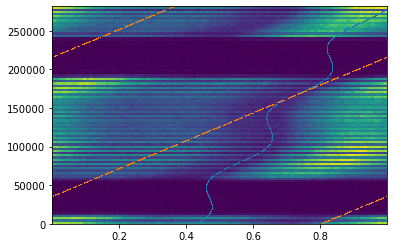

In [21]:
bindata=plt.hist2d(phdata,deltat,bins=100)
plt.plot(-0.044*np.sin(4*np.pi*phaseorb+0.1)+0.4+2e-6*deltat,deltat,',')
plt.plot(np.modf(phaseorb)[0],deltat,',')

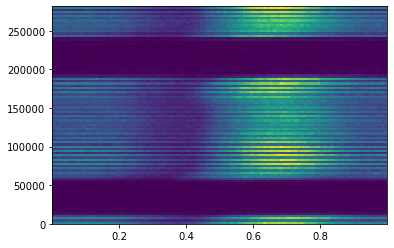

In [22]:
phdata_trial=np.mod(deltat*(respow.x[0]+deltat*respow.x[1]*0.5-2e-6)+0.044*np.sin(4*np.pi*phaseorb+0.1)+np.where(deltat>200000,0.3,0)+np.where(deltat<40000,-0.3,0),1)
bindata=plt.hist2d(phdata_trial,deltat,bins=100)


In [23]:
phdata=phdata_trial

# Unbinned Likelihood Analysis

In [24]:
qdata=evtlist['Q']*moddata
udata=evtlist['U']*moddata

def maxlikephase(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikephaseok(param,_phb,_qd,_ud):
    for _i in range(len(param)//2):
        qloc[_i]=np.cos(2*param[2*_i])*np.tanh(param[2*_i+1])
        uloc[_i]=np.sin(2*param[2*_i])*np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[_phb]*_qd+uloc[_phb]*_ud))))


def maxlikephasequ(param):
    for _i in range(len(param)//2):
        qloc[_i]=np.tanh(param[2*_i])
        uloc[_i]=np.tanh(param[2*_i+1])
#        qloc[_i]=param[2*_i]
#        uloc[_i]=param[2*_i+1]

    return(-np.sum(np.log(1+0.5*(qloc[phbin]*qdata+uloc[phbin]*udata))))

def maxlikefixed(param):
    qloc=param[0]
    uloc=param[1]
    norm=np.hypot(qloc,uloc)
    if norm>1:
        qloc/=norm
        uloc/=norm
    
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

def maxlikerotation(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    _res=-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata)))
    # print(_res,param)
    return _res
def maxlikerotation_rand(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)*np.tanh(param[0])
    uloc=np.sin(2*ang)*np.tanh(param[0])
    if (len(param)>5):
        qloc+=np.tanh(param[5])
        uloc+=np.tanh(param[6])
    return(-np.sum(np.log(1+0.5*(qloc*qrand+uloc*urand))))
def maxlikerotation2(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))
def maxlikerotation2_ok(param,_phd,_qd,_ud):
    ang=angfunk(param[1],param[2],_phd-param[4])+np.radians(param[3])
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(_phd-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8]) 
    return(-np.sum(np.log(1+0.5*(qloc*_qd+uloc*_ud))))
def maxlikerotation2frac(param):
    ang=angfunk(param[1],param[2],phdata-param[4])+np.radians(param[3]+param[4]*tdata)
    qloc=np.cos(2*ang)
    uloc=np.sin(2*ang)
    polfrac=np.tanh(param[0])
    if (len(param)>5):
        polfrac*=(1+param[5]*np.cos(2*np.pi*(phdata-param[6])))
    qloc*=polfrac
    uloc*=polfrac
    if (len(param)>7):
        qloc+=np.tanh(param[7])
        uloc+=np.tanh(param[8])        
    return(-np.sum(np.log(1+0.5*(qloc*qdata+uloc*udata))))

In [25]:
np.savetxt('output/photondata.txt',[phdata,qdata,udata])

In [26]:
ppp_fixed=minimize(maxlikefixed,np.random.normal(size=2)*np.array([0.3,0.3]),method='Nelder-Mead')
ppp_fixed

 final_simplex: (array([[-0.00612425,  0.05610781],
       [-0.00609078,  0.05608075],
       [-0.00611631,  0.0560585 ]]), array([-181.86012736, -181.86012641, -181.86011831]))
           fun: -181.8601273642228
       message: 'Optimization terminated successfully.'
          nfev: 71
           nit: 39
        status: 0
       success: True
             x: array([-0.00612425,  0.05610781])

In [27]:
ppp_rot=minimize(maxlikerotation2,np.random.normal(size=5)*np.array([0.1,50,50,90,1]),method='Nelder-Mead')
if (ppp_rot.x[0]<0):
    ppp_rot.x[0]*=-1
    ppp_rot.x[3]+=90
ppp_rot

 final_simplex: (array([[ 6.27044817e-02, -2.31097417e-04,  8.68337894e-05,
         2.25109453e+02,  1.79613222e+00],
       [-6.27044958e-02, -1.70024469e-04,  6.38859347e-05,
         1.35109454e+02,  1.79613214e+00],
       [-6.27044816e-02, -1.79461702e-04,  6.74319003e-05,
         1.35109464e+02,  1.79613217e+00],
       [-6.27044893e-02, -2.84296448e-04,  1.06823235e-04,
         1.35109457e+02,  1.79613216e+00],
       [-6.27044918e-02, -3.28339331e-04,  1.23372038e-04,
         1.35109461e+02,  1.79613217e+00],
       [-6.27044941e-02, -2.39106335e-04,  8.98432420e-05,
         1.35109453e+02,  1.79613224e+00]]), array([-223.9772857, -223.9772857, -223.9772857, -223.9772857,
       -223.9772857, -223.9772857]))
           fun: -223.9772856982913
       message: 'Optimization terminated successfully.'
          nfev: 843
           nit: 523
        status: 0
       success: True
             x: array([ 6.27044817e-02, -2.31097417e-04,  8.68337894e-05,  2.25109453e+02,
        

In [28]:
ppp_rot2=minimize(maxlikerotation2,np.concatenate((ppp_rot.x,np.random.normal(size=2))),method='Nelder-Mead')
ppp_rot2

 final_simplex: (array([[ 6.00396419e-02, -2.49864123e-04,  9.40995378e-05,
         2.25124510e+02,  1.80252390e+00,  2.31552658e-01,
        -1.14961829e+00],
       [ 6.00396682e-02, -2.49866168e-04,  9.41000352e-05,
         2.25124583e+02,  1.80252378e+00,  2.31551035e-01,
        -1.14961860e+00],
       [ 6.00396241e-02, -2.49863950e-04,  9.40996463e-05,
         2.25124518e+02,  1.80252380e+00,  2.31552730e-01,
        -1.14961688e+00],
       [ 6.00396177e-02, -2.49866986e-04,  9.41003567e-05,
         2.25124557e+02,  1.80252307e+00,  2.31550853e-01,
        -1.14961810e+00],
       [ 6.00397214e-02, -2.49866756e-04,  9.41002312e-05,
         2.25124520e+02,  1.80252323e+00,  2.31551030e-01,
        -1.14961700e+00],
       [ 6.00396870e-02, -2.49863580e-04,  9.40993763e-05,
         2.25124578e+02,  1.80252338e+00,  2.31552913e-01,
        -1.14961615e+00],
       [ 6.00395101e-02, -2.49862273e-04,  9.40984925e-05,
         2.25124565e+02,  1.80252338e+00,  2.31554084e-01,
 

In [29]:
ppp_rot=minimize(maxlikerotation2,ppp_rot2.x[0:-2],method='Nelder-Mead')
ppp_rot

 final_simplex: (array([[ 6.27043851e-02, -2.48749980e-04,  9.34669469e-05,
         2.25109425e+02,  1.79613160e+00],
       [ 6.27043978e-02, -2.48750553e-04,  9.34670234e-05,
         2.25109509e+02,  1.79613134e+00],
       [ 6.27045726e-02, -2.48749504e-04,  9.34669500e-05,
         2.25109440e+02,  1.79613197e+00],
       [ 6.27045618e-02, -2.48750444e-04,  9.34669173e-05,
         2.25109353e+02,  1.79613265e+00],
       [ 6.27043481e-02, -2.48749315e-04,  9.34670868e-05,
         2.25109472e+02,  1.79613247e+00],
       [ 6.27044575e-02, -2.48749726e-04,  9.34671829e-05,
         2.25109326e+02,  1.79613259e+00]]), array([-223.9772857 , -223.9772857 , -223.9772857 , -223.9772857 ,
       -223.9772857 , -223.97728569]))
           fun: -223.97728569720599
       message: 'Optimization terminated successfully.'
          nfev: 179
           nit: 97
        status: 0
       success: True
             x: array([ 6.27043851e-02, -2.48749980e-04,  9.34669469e-05,  2.25109425e+02,
  

# Binned Analysis

In [30]:
qloc=np.zeros(10)
uloc=np.zeros(10)
phbin=(phdata//0.1).astype(int)
ppp_phase=minimize(maxlikephase,np.random.uniform(size=20))
ppp_phase_err=np.diag(ppp_phase.hess_inv)**0.5    

In [31]:
ppp_phasequ=minimize(maxlikephasequ,(np.arange(20)+1)*0.2)
ppp_phasequ_err=np.diag(ppp_phasequ.hess_inv)**.5

In [32]:
tt=np.sum(toton[0].reshape((10,10)),axis=1)
phlist=np.linspace(0.05,0.95,10)
with open('output/QU_phase.dat','w') as f:
    print('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts')
    f.write('#    Phase        Q/I       EQ/I        U/I       EU/I     Counts\n')

    for r in zip(phlist,np.tanh(ppp_phasequ.x[::2]),np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,
                 np.tanh(ppp_phasequ.x[1::2]),np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,tt):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Phase        Q/I       EQ/I        U/I       EU/I     Counts
      0.05   0.042176  0.0102605  0.0191112  0.0128878     306827 
      0.15  0.0144441  0.0103016  0.0075652   0.014033     236965 
      0.25 0.00498682  0.0104414  0.0265791  0.0100914     201665 
      0.35 -0.0682125  0.0160734  0.0988263  0.0134848     187796 
      0.45 -0.0501933  0.0108781    0.10532  0.0116016     165499 
      0.55 -0.0220746  0.0135137  0.0297856  0.0107601     132835 
      0.65 -0.0101819  0.0071835  0.0436161 0.00705831     136293 
      0.75 -0.0237692  0.0069664   0.061699 0.00753534     219803 
      0.85 -0.00506659 0.00966128   0.106281  0.0140362     320677 
      0.95  0.0436714 0.00979093          1 2.25583e-10     356951 


In [33]:
with open('output/pol_phase.dat','w') as f:
    print('#    Phase         PD        EPD         PA        EPA     Counts')
    f.write('#    Phase         PD        EPD         PA        EPA     Counts\n')
    for r in zip((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2]),180),
        np.degrees(ppp_phase_err[::2]),tt):
        print('%10g '*6 %r)
        f.write(('%10g '*6 %r)+'\n')
        

#    Phase         PD        EPD         PA        EPA     Counts
      0.05  0.0463039 0.00988271    12.1883    7.81452     306827 
      0.15  0.0163053 0.00959612    13.8219    19.1204     236965 
      0.25  0.0270429  0.0112792    39.6868    13.8739     201665 
      0.35   0.120082  0.0160488    62.3072    3.37164     187796 
      0.45   0.116669  0.0119364    57.7408    3.18039     165499 
      0.55  0.0370738  0.0105256    63.2714    7.36632     132835 
      0.65  0.0447888 0.00782267      51.57     9.8883     136293 
      0.75  0.0661192  0.0118734    55.5345     3.5127     219803 
      0.85   0.106401 0.00914459    46.3647    2.17228     320677 
      0.95    0.10459  0.0102528    32.2757    2.58156     356951 


Text(0, 0.5, 'U/I')

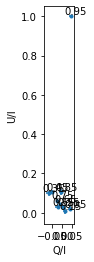

In [34]:
#plt.figure(figsize=(6,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),yerr=np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_phasequ.x[::2]),np.tanh(ppp_phasequ.x[1::2]),np.linspace(0.05,0.95,10)):
    plt.text(_xx-3e-2,_yy+1e-2,'%.2f' % _tt)
plt.xlabel('Q/I')
plt.ylabel('U/I')

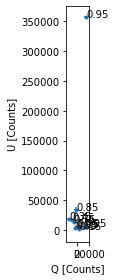

In [35]:
#plt.figure(figsize=(7,4))
plt.gca().set_aspect('equal')
plt.errorbar(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,yerr=tt*np.diag(ppp_phasequ.hess_inv)[1::2]**0.5/np.cosh(ppp_phasequ.x[1::2])**2,xerr=tt*np.diag(ppp_phasequ.hess_inv)[::2]**0.5/np.cosh(ppp_phasequ.x[::2])**2,fmt='.')
for _xx,_yy,_tt,_qq in zip(np.tanh(ppp_phasequ.x[::2])*tt,np.tanh(ppp_phasequ.x[1::2])*tt,phlist,tt):
    plt.text(_xx-3e+1,_yy+1e+1,'%.2f' % (_tt))
param=ppp_rot2.x
ang=angfunk(param[1],param[2],phlist-param[4])+np.radians(param[3])
polfrac=np.tanh(param[0])
if (len(param)>5):
    polfrac*=(1+param[5]*np.cos(2*np.pi*(phlist-param[6])))

qloc=np.cos(2*ang)*polfrac*60000
uloc=np.sin(2*ang)*polfrac*60000
#plt.plot(qloc,uloc)  
#plt.xlim(-18000,5000)
#plt.ylim(0,12000)
#plt.ylim(-0.1,0.3)
plt.xlabel('Q [Counts]')
plt.ylabel('U [Counts]')
plt.tight_layout()
plt.savefig('figures/QU.pdf')

# Plots

In [36]:
def plottwo(x,y,yerr,fmt):
    _x=np.concatenate((x,x+1))
    _y=np.concatenate((y,y))
    _yerr=np.concatenate((yerr,yerr))
    plt.errorbar(_x,_y,xerr=(_x[1]-_x[0])/2,yerr=_yerr,fmt=fmt)

In [37]:
def cfunk(p,a,b,c):
    return(a*np.cos((p-b)*2*np.pi)+c)

cfit=curve_fit(cfunk,0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],sigma=(toton[0])**0.5)
pfit=curve_fit(cfunk,(np.arange(len(ppp_phase.x)//2)+0.5)/10,100*np.abs(np.tanh(ppp_phase.x[1::2])),sigma=100*ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2)

0.6529669309767366


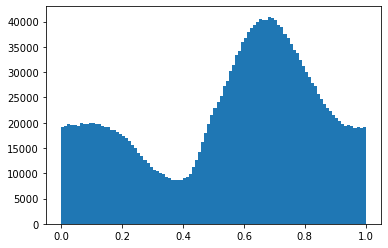

In [38]:
toton=plt.hist(phdata,bins=100)
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()))

0.6529669309767366 0.42332375678904743


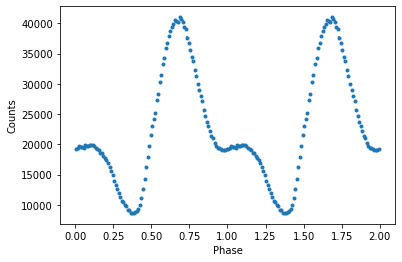

In [39]:

_ph=np.linspace(0,2,201)
plottwo(0.5*toton[1][:-1]+0.5*toton[1][1:],toton[0],(toton[0])**0.5,'.')
#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')
print((toton[0].max()-toton[0].min())/(toton[0].max()+toton[0].min()),cfit[0][0]/cfit[0][2])
plt.savefig('figures/intensity.pdf')

0.06853759182935774 0.00350398903602702


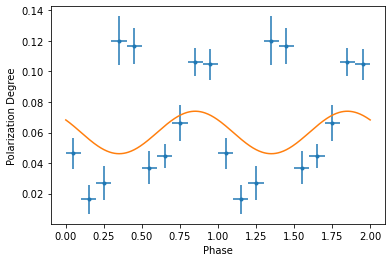

In [40]:
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))))
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
plt.savefig('figures/polar-deg.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      180
Beta:                       9.40995e-05
Mean Polarization Fraction: 0.0599676
Ampl Polarization Fraction: 0.0138857
Peak Polarization Fraction: 0.850382
Pole across Line of Sight:  0.802524
Peak Flux:                  0.997864


Alpha:                      180
Beta:                       9.34669e-05
Mean Polarization Fraction: 0.0626223
Pole across Line of Sight:  0.796132
Peak Flux:                  0.997864



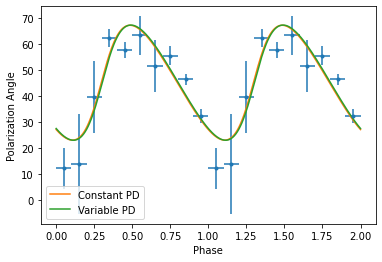

In [41]:
shift=0
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Ampl Polarization Fraction: %g
Peak Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % ((ppp_rot2.x[1]%180,ppp_rot2.x[2])+tuple(np.mod(np.array([np.abs(np.tanh(ppp_rot2.x[0])),np.abs(ppp_rot2.x[5]*np.tanh(ppp_rot2.x[0])),
                                                            ppp_rot2.x[6],
                                                            ppp_rot2.x[4]+(0 if ppp_rot2.x[2]>0 else 0.5),
                                                            (cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5)]),1))))
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))

if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='Constant PD')

if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift,label='Variable PD')

#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle.pdf')

# Energy Dependence

In [42]:
pibin=np.clip(((evtlist['PI']-50)//25).astype(int),0,4)
def maxlikeenergy(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[2*pibin])*qrot+np.tanh(param[2*pibin+1])*urot))))
def maxlikeenergy2(param):
    return(-np.sum(np.log(1+0.5*(np.tanh(param[pibin])*qrot))))


In [43]:
angdata=angfunk( ppp_rot.x[1],  ppp_rot.x[2], phdata-ppp_rot.x[4])+np.radians(ppp_rot.x[3])

sangdata=np.sin(2*angdata)
cangdata=np.cos(2*angdata)
urot=evtlist['U']*cangdata-evtlist['Q']*sangdata
qrot=evtlist['U']*sangdata+evtlist['Q']*cangdata
um,qm=np.mean(urot/moddata),np.mean(qrot/moddata)
print(um,qm,np.hypot(um,qm),np.std(qrot/moddata)/len(qrot)**0.5,np.std(qrot)/np.mean(moddata)/len(qrot)**0.5)
urot*=moddata
qrot*=moddata

0.0044074963605380555 0.06753796790568499 0.06768163069103382 0.003646631851242423 0.0030847769887952094


In [44]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=5)-0.5)

In [45]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=10)-0.5)

Text(0, 0.5, 'U/I')

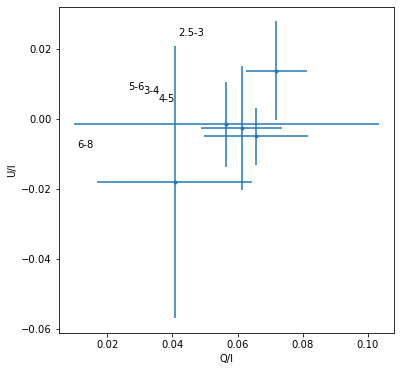

In [46]:
plt.figure(figsize=(6,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_tt in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),['2.5-3','3-4','4-5','5-6','6-8']):
    plt.text(_xx-3e-2,_yy+1e-2,_tt)
#plt.xlim(-0.29,0.29)
#plt.ylim(-0.29,0.29)
plt.xlabel('Q/I')
plt.ylabel('U/I')

Text(0, 0.5, 'Q/I')

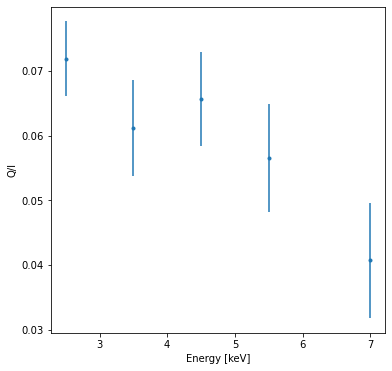

In [47]:
plt.figure(figsize=(6,6))
_xxx=[2.5,3.5,4.5,5.5,7]
plt.errorbar(_xxx,np.tanh(ppp_spec_deg.x),yerr=np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2,fmt='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')

# Bin optimization

In [48]:
_ii=np.argsort(evtlist['PI'])
pisort=evtlist['PI'][_ii]
modsort=moddata[_ii]

In [49]:
modcum=np.cumsum(modsort)
def mdpfunk(imin,imax):
    return(4.29/((modcum[imax]-modcum[imin])/(imax-imin))/(imax-imin)**0.5)
def mdppi(pimin,pimax):
    _imin=np.interp(pimin,pisort,range(len(pisort))).astype(int)
    _imax=np.interp(pimax,pisort,range(len(pisort))).astype(int)

    return mdpfunk(_imin,_imax)

In [50]:
modscum=np.cumsum(modsort**2)

In [51]:
plist=np.interp(np.linspace(0,1,70),modscum/modscum[-1],np.arange(len(modcum))).astype(int)
plist

array([      0,  152074,  265421,  358914,  439722,  511267,  576336,
        635829,  691062,  743093,  792303,  838945,  883990,  926747,
        967432, 1006285, 1043967, 1080990, 1116765, 1151151, 1184437,
       1217060, 1249246, 1280467, 1310760, 1341054, 1370687, 1398961,
       1427235, 1455170, 1482090, 1508597, 1535104, 1561353, 1586770,
       1611717, 1636665, 1661529, 1685090, 1708652, 1732214, 1755775,
       1779337, 1802899, 1824109, 1845314, 1866520, 1887725, 1908931,
       1930136, 1951176, 1970782, 1990060, 2009337, 2028615, 2047844,
       2065836, 2083508, 2101179, 2118759, 2135177, 2151489, 2167555,
       2182701, 2197822, 2212046, 2226180, 2239562, 2252800, 2265310])

In [52]:
for ii in range(len(plist)-1):
    _imin=plist[ii]
    _imax=plist[ii+1]
    _pmin,_pmax=pisort[_imin],pisort[_imax]
    # print(ii,_pmin,_pmax,_pmin/25,_pmax/25,mdpfunk(plist[ii],plist[ii+1]))

In [53]:
pilist=np.concatenate((pisort[plist[0:65:5]],pisort[plist[65:]]))
elist=pilist/25

In [54]:
pibin=np.digitize(evtlist['PI'],pilist)-1
pibin.min(),pibin.max()

(0, 17)

In [55]:
ppp_spec_deg=minimize(maxlikeenergy2,np.random.uniform(size=pibin.max()+1)-0.5)

In [56]:
ppp_spec_qu=minimize(maxlikeenergy,np.random.uniform(size=2*pibin.max()+2)-0.5)

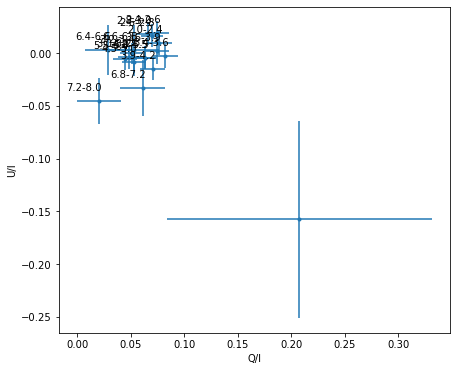

In [57]:
plt.figure(figsize=(7,6))
plt.errorbar(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),yerr=np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,xerr=np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,fmt='.')
for _xx,_yy,_e0,_e1 in zip(np.tanh(ppp_spec_qu.x[::2]),np.tanh(ppp_spec_qu.x[1::2]),elist[:-1],elist[1:]):
    plt.text(_xx-3e-2,_yy+1e-2,'%.1f-%.1f' % (_e0,_e1))
#plt.xlim(-0.4,0.3)
#plt.ylim(-0.3,0.3)
plt.xlabel('Q/I')
plt.ylabel('U/I')
plt.savefig('figures/QU-energy_v1.pdf')

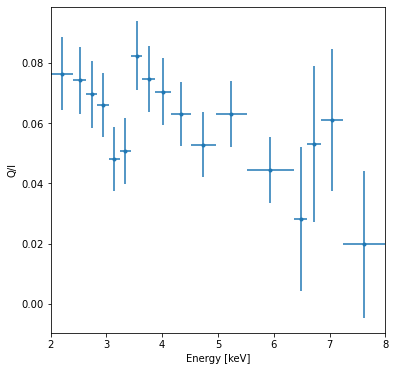

In [58]:
plt.figure(figsize=(6,6))

plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             yerr=(np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.')
plt.xlim(2,8)

plt.xlabel('Energy [keV]')
plt.ylabel('Q/I')
plt.savefig('figures/polar-energy.pdf')
np.save('output/qoveri',[0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
             (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
             0.5*(-elist[:-1]+elist[1:])])

In [59]:
with open('output/poldeg_energy.dat','w') as f:
    print('#     Emid        Q/I       EQ/I   DeltaE/2')
    f.write('#     Emid        Q/I       EQ/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_deg.x)[:-1],
                 (np.diag(ppp_spec_deg.hess_inv)**0.5/np.cosh(ppp_spec_deg.x)**2)[:-1],
                 0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*4) % r)
        f.write((('%10g '*4) % r)+'\n')

#     Emid        Q/I       EQ/I   DeltaE/2
       2.2  0.0764106  0.0121109        0.2 
      2.52  0.0742603  0.0111881       0.12 
      2.74  0.0695722  0.0111753        0.1 
      2.94  0.0660105  0.0107367        0.1 
      3.14  0.0480172  0.0107275        0.1 
      3.34  0.0508733  0.0109387        0.1 
      3.54   0.082324  0.0114486        0.1 
      3.76  0.0747562  0.0109253       0.12 
      4.02  0.0704831  0.0110709       0.14 
      4.34  0.0630806  0.0106542       0.18 
      4.74  0.0527985   0.010838       0.22 
      5.24  0.0629835  0.0110607       0.28 
      5.94  0.0445247   0.010932       0.42 
      6.48  0.0281666  0.0239453       0.12 
      6.72  0.0529529  0.0258811       0.12 
      7.04    0.06105  0.0235153        0.2 
      7.62  0.0196785  0.0244128       0.38 


In [60]:
with open('output/QU_energy.dat','w') as f:
    print('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2')
    f.write('#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2\n')

    for r in zip(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x[::2]),np.diag(ppp_spec_qu.hess_inv)[::2]**0.5/np.cosh(ppp_spec_qu.x[::2])**2,
                 np.tanh(ppp_spec_qu.x[1::2]),np.diag(ppp_spec_qu.hess_inv)[1::2]**0.5/np.cosh(ppp_spec_qu.x[1::2])**2,
                0.5*(-elist[:-1]+elist[1:])):
        print(('%10g '*6) % r)
        f.write((('%10g '*6) % r)+'\n')

#    Emid         Q/I       EQ/I        U/I       EU/I   DeltaE/2
       2.2  0.0764047  0.0116218 0.00942071  0.0117507        0.2 
      2.52  0.0742715  0.0110629  0.0187167  0.0111243       0.12 
      2.74  0.0695629  0.0103345  0.0165411  0.0109952        0.1 
      2.94  0.0659783  0.0109933  0.0184169   0.010672        0.1 
      3.14  0.0480144  0.0101975 -0.0039438    0.01086        0.1 
      3.34  0.0508743  0.0107449 -0.000385424 0.00983497        0.1 
      3.54  0.0823278  0.0113891 -0.0029091  0.0112208        0.1 
      3.76  0.0747549  0.0108259 0.00155015  0.0115936       0.12 
      4.02   0.070449  0.0116531 -0.0154494  0.0106167       0.14 
      4.34  0.0630794  0.0102792 -0.00454255  0.0109404       0.18 
      4.74  0.0528208   0.011135 -0.00862167  0.0103391       0.22 
      5.24  0.0630093  0.0109127 -0.0045495  0.0110339       0.28 
      5.94  0.0445108   0.011436 -0.00566144  0.0109234       0.42 
      6.48  0.0281728  0.0215028 0.00283047  0.0240263    

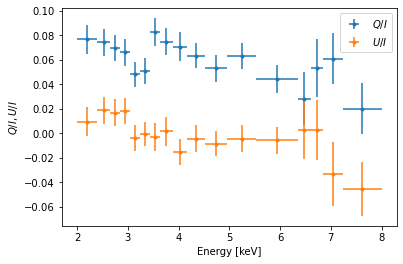

In [61]:
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[:-2:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[:-2:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$Q/I$')
plt.errorbar(0.5*(elist[:-1]+elist[1:]),np.tanh(ppp_spec_qu.x)[1:-1:2],
             yerr=(np.diag(ppp_spec_qu.hess_inv)**0.5/np.cosh(ppp_spec_qu.x)**2)[1:-1:2],
             xerr=0.5*(-elist[:-1]+elist[1:]),fmt='.',label=r'$U/I$')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$Q/I, U/I$')
plt.savefig('figures/QU-energy_v2.pdf')

# Energy Dependence of Phase-Resolved

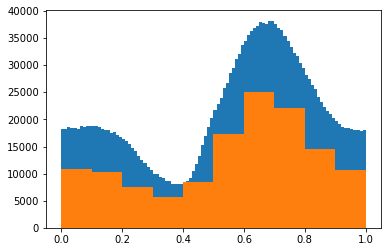

In [62]:
oklow=evtlist['PI']<=5.5*25
totonl=plt.hist(phdata[oklow],bins=100)
totonh=plt.hist(phdata[~oklow],bins=10)

Text(0.5, 0, 'Phase')

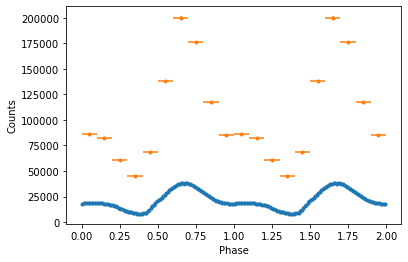

In [63]:
_ph=np.linspace(0,2,201)
plottwo(0.5*totonl[1][:-1]+0.5*totonl[1][1:],totonl[0],(totonl[0])**0.5,'.')
_ph=np.linspace(0,2,21)
plottwo(0.5*totonh[1][:-1]+0.5*totonh[1][1:],8*totonh[0],8*(totonh[0])**0.5,'.')

#plt.plot(_ph,cfunk(_ph,*cfit[0]))
plt.ylabel('Counts')
plt.xlabel('Phase')

In [64]:
ppp_rot_low=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[oklow],qdata[oklow],udata[oklow]))
ppp_rot_high=minimize(maxlikerotation2_ok,ppp_rot2.x,method='Nelder-Mead',args=(phdata[~oklow],qdata[~oklow],udata[~oklow]))

In [65]:
np.save("output/totonh.npy",totonh)
np.save("output/totonl.npy",totonl)
np.save('output/ppp_rot',(ppp_rot2,ppp_rot_low,ppp_rot_high))

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


0.06853759182935774 0.00350398903602702


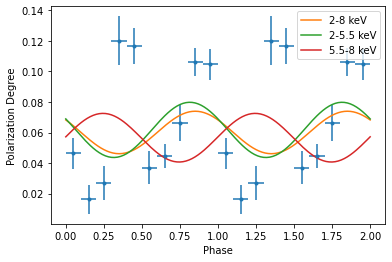

In [66]:
_ph=np.linspace(0,2,201)
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.abs(np.tanh(ppp_phase.x[1::2])),ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2])**2,'.')
#plt.plot(_ph,cfunk(_ph,*pfit[0])/100)
plt.plot(_ph,np.abs(ppp_rot2.x[0]*(1+ppp_rot2.x[5]*np.cos(2*np.pi*(_ph-ppp_rot2.x[6])))),label='2-8 keV')
plt.plot(_ph,np.abs(ppp_rot_low.x[0]*(1+ppp_rot_low.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_low.x[6])))),label='2-5.5 keV')
plt.plot(_ph,np.abs(ppp_rot_high.x[0]*(1+ppp_rot_high.x[5]*np.cos(2*np.pi*(_ph-ppp_rot_high.x[6])))),label='5.5-8 keV')
plt.ylabel('Polarization Degree')
plt.xlabel('Phase')
#plt.ylim(0.1,0.6)
plt.legend()
plt.savefig('figures/polar-deg-energy.pdf')
print(np.mean(np.abs(np.tanh(ppp_phase.x[1::2]))),np.sum((ppp_phase_err[1::2]/np.cosh(ppp_phase.x[1::2]))**2)**0.5/10)


Alpha:                      180
Beta:                       9.34669e-05
Mean Polarization Fraction: 0.0626223
Pole across Line of Sight:  0.796132
Peak Flux:                  0.997864



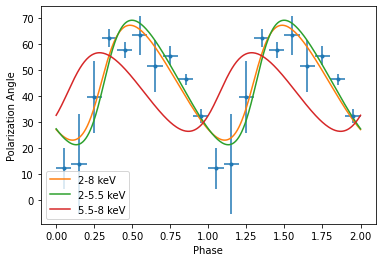

In [67]:
shift=0
plottwo((np.arange(len(ppp_phase.x)//2)+0.5)/(len(ppp_phase.x)//2),np.mod(np.degrees(np.where(ppp_phase.x[1::2]>0,0,np.pi*0.5)+ppp_phase.x[::2])-shift,180)+shift,np.degrees(ppp_phase_err[::2]),'.')
_ph=np.linspace(0,2,401)
print('''
Alpha:                      %g
Beta:                       %g
Mean Polarization Fraction: %g
Pole across Line of Sight:  %g
Peak Flux:                  %g
''' % (ppp_rot.x[1]%180,ppp_rot.x[2],np.abs(np.tanh(ppp_rot.x[0])),np.mod(ppp_rot.x[4]+(0 if ppp_rot.x[2]>0 else 0.5),1),
                                                            np.mod(cfit[0][1] if cfit[0][0]>0 else cfit[0][1]-0.5,1)))

if ppp_rot.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift,label='2-8 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_low.x[1],ppp_rot_low.x[2],_ph-ppp_rot_low.x[4])+np.radians(ppp_rot_low.x[3]-shift)),np.pi))+shift,label='2-5.5 keV')
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot_high.x[1],ppp_rot_high.x[2],_ph-ppp_rot_high.x[4])+np.radians(ppp_rot_high.x[3]-shift)),np.pi))+shift,label='5.5-8 keV')
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot.x[1],ppp_rot.x[2],_ph-ppp_rot.x[4])+np.radians(ppp_rot.x[3]-shift)),np.pi))+shift)

'''if ppp_rot2.x[0]>0:
    plt.plot(_ph,np.degrees(np.mod((angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
else:
    plt.plot(_ph,np.degrees(np.mod(np.pi/2+(angfunk(ppp_rot2.x[1],ppp_rot2.x[2],_ph-ppp_rot2.x[4])+np.radians(ppp_rot2.x[3]-shift)),np.pi))+shift)
    '''
#plt.ylim(25,75)
plt.ylabel('Polarization Angle')
plt.xlabel('Phase')
plt.legend()
plt.savefig('figures/polar-angle-energy.pdf')